MARIO. Instalo pytorch con CUDA 11.8, que es compatible con mi GPU GTX 970
----------------
El notebook alterna entre el inglés y el español, el inglés son comentarios propios del tutorial, en español los míos.

pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Después de varias pruebas alternando entre CPU y GPU concluyo que en este caso no hay una diferencia significativa, debido a que el volumen de datos no es tan grande como para generar una diferencia y a que la GPU no es moderna.

In [18]:
import torch
import torchvision
import torchvision.transforms as transforms

#MARIO.
import time
import os

In [19]:
inicio = time.time() #MARIO. Inicio del temporizador

# Compruebo si hay GPU disponible y selecciono el dispositivo adecuado
device = (
    "cuda" if torch.cuda.is_available() # CUDA: Compute Unified Device Architecture (NVIDIA)
    else "mps" if torch.backends.mps.is_available() # MPS: Metal Performance Shaders (Apple)
    #else "hip" if torch.hip.is_available() # HIP: Heterogeneous-compute Interface for Portability (AMD - ROCm)
    else "cpu" 
)

#MARIO. Código para forzar el uso de CPU.
#device = "cpu"

if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
elif device == "mps":
    print("MPS is available.")
elif device == "hip":
    print("HIP is available.")
else:
    print("No GPU available. Training will run on CPU.")


GPU: NVIDIA GeForce GTX 970 is available.


In [20]:
# Descarga el dataset CIFAR-10 y calcula la media y desviación estándar de las imágenes
# Vamos a estratificar el dataset en entrenamiento y validación, y luego cargarlo en DataLoaders para su uso en el entrenamiento de un modelo de red neuronal.

import torch
import torchvision
import torchvision.transforms as transforms

from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from torch.utils.data import Subset

# Paso 1: Cargar el dataset con solo ToTensor para calcular estadísticas (media y std)
transform_tmp = transforms.ToTensor()
trainset_tmp = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform_tmp)

trainloader_tmp = torch.utils.data.DataLoader(trainset_tmp, batch_size=50000, shuffle=False)
data = next(iter(trainloader_tmp))
images, _ = data  # ignoramos las etiquetas

# Paso 2: Calcular media y desviación estándar por canal (dimensiones: [batch, channel, height, width])
mean = images.mean(dim=[0, 2, 3])  # Media por canal
std = images.std(dim=[0, 2, 3])    # Desviación estándar por canal

print("Media por canal:", mean)
print("Desviación estándar por canal:", std)

# Paso 3: Usar los valores calculados en la transformación final
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())  # Normalización con media y std calculados
])

# Paso 4: Cargar los datasets normales con la transformación final
batch_size = 32  # Tamaño del lote
workers = os.cpu_count() // 2 # Número de workers para cargar datos (ajustar según la capacidad de la CPU). La mitad de los núcleos disponibles.

full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

# Dividir en entrenamiento y validación

#train_size = int(0.8 * len(full_trainset))  # 40,000 imágenes
#val_size = len(full_trainset) - train_size  # 10,000 imágenes
#trainset, valset = torch.utils.data.random_split(full_trainset, [train_size, val_size])  # mantenemos 'trainset'

# Usar StratifiedShuffleSplit para asegurar que la proporción de clases se mantenga en ambos conjuntos, en este caso no es tan relevante porque el dataset es balanceado, pero es una buena práctica.
# Obtener las etiquetas del dataset completo
targets = np.array(full_trainset.targets)

# Crear el generador de splits estratificados
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(splitter.split(np.zeros(len(targets)), targets))
trainset = Subset(full_trainset, train_idx)
valset = Subset(full_trainset, val_idx)


# DataLoaders

full_trainloader = torch.utils.data.DataLoader(full_trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=workers)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=workers)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                        shuffle=False, num_workers=workers)

# Conjunto de prueba (sin cambios)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=workers)

# Clases del dataset
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Imprimir cantidad de imágenes en los datasets de entrenamiento y prueba
print(f"Número de imagenes en dataset total de entrenamiento: {len(full_trainset)}")
print(f"Número de imágenes de entrenamiento: {len(trainset)}")
print(f"Número de imágenes de validación: {len(valset)}")
print(f"Número de imágenes de prueba: {len(testset)}")


Media por canal: tensor([0.4914, 0.4822, 0.4465])
Desviación estándar por canal: tensor([0.2470, 0.2435, 0.2616])
Número de imagenes en dataset total de entrenamiento: 50000
Número de imágenes de entrenamiento: 40000
Número de imágenes de validación: 10000
Número de imágenes de prueba: 10000


Let us show some of the training images, for fun.


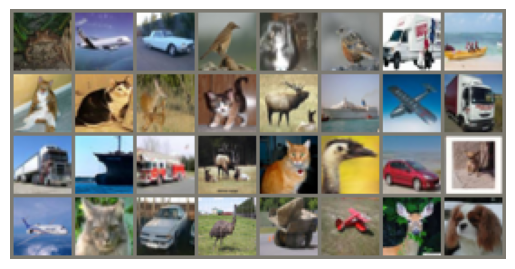

frog  plane car   bird  dog   bird  truck ship  cat   cat   deer  dog   deer  ship  plane truck truck ship  truck deer  cat   bird  car   dog   plane cat   car   bird  truck plane deer  dog  


In [21]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Función para desnormalizar y mostrar imágenes teniendo en cuenta la media y desviación estándar calculadas
def imshow(img, mean, std):
    img = img.clone().cpu()  # por seguridad
    for c in range(3):  # canal R, G, B
        img[c] = img[c] * std[c] + mean[c]
    img = np.clip(img.numpy(), 0, 1)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Obtener algunas imágenes aleatorias del conjunto de entrenamiento
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Mostrar una cuadrícula de imágenes
img_grid = torchvision.utils.make_grid(images)
imshow(img_grid, mean, std)

# Mostrar etiquetas
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


2. Definición de las distintas redes neuronales convolucionales. La primera es el Baseline, las siguientes son las propuestas de mejoras.


In [22]:
import torch.nn as nn
import torch.nn.functional as F

'''
BASELINE: Definición de la red neuronal convolucional para CIFAR-10.
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
'''


'''
Modelo mejorado Red Neuronal 1 para CIFAR-10. Después de las pruebas he detectado que esta es la mejor.

Mayor profundidad moderada:
Cuatro capas convolucionales (vs. dos en la original), lo que permite captar características más complejas sin sobrecargar el modelo.

Uso de Batch Normalization tras cada capa:
Estabiliza y acelera el entrenamiento, permitiendo el uso de tasas de aprendizaje más altas y mejor generalización.

Dropout bien ubicado y progresivo:

0.25 tras las convoluciones intermedias

0.5 tras la capa densa
Esto combate eficazmente el sobreajuste.

Aumento gradual de filtros:
Usa 32 → 64 → 128 filtros, lo que mejora la capacidad de aprendizaje de patrones sin ser excesivo.

Diseño balanceado y eficiente:
Usa MaxPool2d para reducir el tamaño de las imágenes gradualmente, lo que mantiene la eficiencia computacional.

Capa densa intermedia (512 unidades):
Añade capacidad de clasificación sin hacer el modelo innecesariamente grande.
'''

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Primera capa convolucional: entrada 3 canales, salida 32 filtros
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # BatchNorm mejora la estabilidad
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Segunda capa convolucional: entrada 32, salida 64
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.dropout1 = nn.Dropout(0.25)  # Previene sobreajuste

        # Tercera capa convolucional: entrada 64, salida 128
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Cuarta capa convolucional: mantiene salida en 128
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Capa totalmente conectada: input 128 * 4 * 4 = 2048
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.dropout2 = nn.Dropout(0.5)  # Más agresivo para evitar sobreajuste
        self.fc2 = nn.Linear(512, 10)  # CIFAR-10: 10 clases

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # [B, 32, 16, 16]
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # [B, 64, 8, 8]
        x = self.dropout1(x)
        x = F.relu(self.bn3(self.conv3(x)))             # [B, 128, 8, 8]
        x = self.pool2(F.relu(self.bn4(self.conv4(x)))) # [B, 128, 4, 4]
        x = x.view(x.size(0), -1)                       # Flatten: [B, 2048]
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x


'''
Modelo mejorado Red Neuronal 2 para CIFAR-10.

Mayor profundidad:
Pasa de 2 a 4 capas convolucionales para aprender características más complejas.

Más filtros:
Usa más canales (de 64 a 256) para captar más patrones visuales.

Batch Normalization:
Acelera y estabiliza el entrenamiento, y ayuda a prevenir overfitting.

Dropout regular:
Evita el sobreajuste desactivando neuronas aleatoriamente durante el entrenamiento.

Capa densa intermedia:
Agrega una capa totalmente conectada adicional para mejorar la capacidad de clasificación.

Uso eficiente del MaxPooling:
Reduce el tamaño de los mapas de activación y mejora la generalización.

'''
'''
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Primer bloque convolucional
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        
        # Segundo bloque convolucional
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        
        # Tercer bloque convolucional
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        
        # Cuarto bloque convolucional (más profundo)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        # Capa de pooling y regularización
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)

        # Capa completamente conectada
        self.fc1 = nn.Linear(256 * 2 * 2, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # Bloque 1
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout(x)
        
        # Bloque 2
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        
        # Bloque 3
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout(x)
        
        # Bloque 4
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.dropout(x)
        
        # Aplanar y pasar por las capas totalmente conectadas
        x = x.view(-1, 256 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
'''


net = Net()

#MARIO. Envío el modelo a la GPU si está disponible.
net.to(device)


Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (f

**3. Definición de la función de pérdida y el optimizador**
----------------


In [23]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(net.parameters(), lr=0.001, weight_decay=1e-4)
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

MARIO. Entrenamiento con validación y curvas

In [24]:
epochs = 10 # Número de épocas para el entrenamiento
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
# Entrenar el modelo
start_time = time.time()  # justo antes del bucle de entrenamiento
for epoch in range(epochs):
    epoch_start = time.time()  # inicio de la época
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data in trainloader:
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(trainloader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validación
    net.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for data in valloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_loss / len(valloader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Época {epoch+1}: '
          f'Train Loss={train_loss:.3f}, Acc={train_acc:.2f}% | '
          f'Val Loss={val_loss:.3f}, Acc={val_acc:.2f}% | '
          f'Tiempo: {time.time() - epoch_start:.2f} s')
    
total_time = time.time() - start_time
print(f'\n Tiempo total de entrenamiento: {total_time:.2f} segundos')
    

Época 1: Train Loss=1.477, Acc=46.20% | Val Loss=1.202, Acc=57.51% | Tiempo: 46.61 s
Época 2: Train Loss=1.122, Acc=60.50% | Val Loss=0.966, Acc=66.47% | Tiempo: 46.61 s
Época 3: Train Loss=0.962, Acc=66.38% | Val Loss=0.925, Acc=67.63% | Tiempo: 45.89 s
Época 4: Train Loss=0.853, Acc=70.11% | Val Loss=0.756, Acc=73.51% | Tiempo: 45.45 s
Época 5: Train Loss=0.773, Acc=73.45% | Val Loss=0.692, Acc=75.51% | Tiempo: 46.11 s
Época 6: Train Loss=0.703, Acc=75.75% | Val Loss=0.650, Acc=77.54% | Tiempo: 46.04 s
Época 7: Train Loss=0.642, Acc=77.84% | Val Loss=0.661, Acc=77.21% | Tiempo: 45.56 s
Época 8: Train Loss=0.590, Acc=79.78% | Val Loss=0.677, Acc=77.69% | Tiempo: 47.02 s
Época 9: Train Loss=0.544, Acc=81.30% | Val Loss=0.623, Acc=79.11% | Tiempo: 46.36 s
Época 10: Train Loss=0.507, Acc=82.56% | Val Loss=0.575, Acc=80.96% | Tiempo: 46.39 s

 Tiempo total de entrenamiento: 462.03 segundos


MARIO.Graficar curvas de aprendizaje

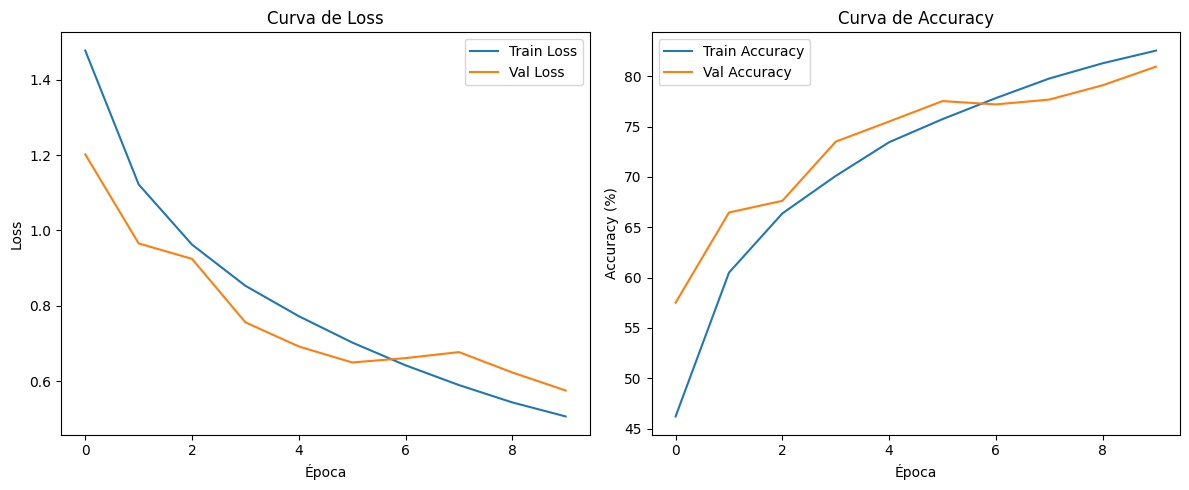

In [25]:
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Curva de Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy (%)')
plt.title('Curva de Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


**4. Entrenar la red neuronal con el full train dataset**
----------------


In [26]:
epochs = 10  # Número de épocas para el entrenamiento con el conjunto completo
net.train()  # Modo de entrenamiento

for epoch in range(epochs):
    running_loss = 0.0
    total = 0
    correct = 0

    for i, data in enumerate(full_trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Estadísticas de precisión en entrenamiento (opcional)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(full_trainloader)
    epoch_acc = 100 * correct / total
    print(f'Época {epoch+1}: Loss={epoch_loss:.3f}, Accuracy={epoch_acc:.2f}%')

print('Entrenamiento completado con el conjunto completo.')


Época 1: Loss=0.523, Accuracy=82.21%
Época 2: Loss=0.488, Accuracy=83.47%
Época 3: Loss=0.448, Accuracy=84.62%
Época 4: Loss=0.418, Accuracy=85.48%
Época 5: Loss=0.391, Accuracy=86.50%
Época 6: Loss=0.371, Accuracy=87.32%
Época 7: Loss=0.347, Accuracy=88.13%
Época 8: Loss=0.330, Accuracy=88.54%
Época 9: Loss=0.308, Accuracy=89.18%
Época 10: Loss=0.294, Accuracy=89.71%
Entrenamiento completado con el conjunto completo.


Let\'s quickly save our trained model:


In [27]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

5. Test the network on the test data


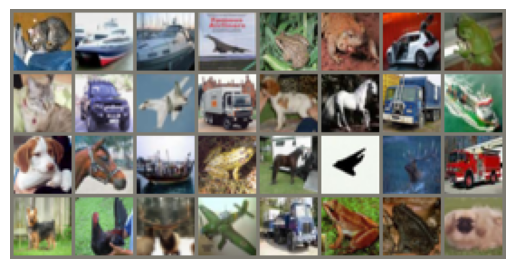

GroundTruth:  cat   ship  ship  plane


In [28]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
# Mostrar una cuadrícula de imágenes
img_grid = torchvision.utils.make_grid(images)
imshow(img_grid, mean, std)
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let\'s load back in our saved model (note: saving and re-loading
the model wasn\'t necessary here, we only did it to illustrate how to do
so):


In [29]:
net = Net()

net.load_state_dict(torch.load(PATH, weights_only=True))

#MARIO. Envío el modelo a la GPU si está disponible.
net.to(device)
images, labels = images.to(device), labels.to(device)


Okay, now let us see what the neural network thinks these examples above
are:


In [30]:
outputs = net(images)

The outputs are energies for the 10 classes. The higher the energy for a
class, the more the network thinks that the image is of the particular
class. So, let\'s get the index of the highest energy:


In [31]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.


In [32]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        
        #MARIO. Envío los datos a la GPU si está disponible.
        images, labels = images.to(device), labels.to(device)
        
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 78 %


In [33]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        #MARIO. Envío los datos a la GPU si está disponible.
        images, labels = images.to(device), labels.to(device)
        
        
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    

Accuracy for class: plane is 80.8 %
Accuracy for class: car   is 85.3 %
Accuracy for class: bird  is 69.8 %
Accuracy for class: cat   is 63.4 %
Accuracy for class: deer  is 79.1 %
Accuracy for class: dog   is 75.1 %
Accuracy for class: frog  is 83.1 %
Accuracy for class: horse is 79.9 %
Accuracy for class: ship  is 87.2 %
Accuracy for class: truck is 86.1 %


In [34]:
# borramos el dataiter para liberar memoria
del dataiter

#MARIO. Medimos el tiempo de ejecución
fin = time.time()
print(f"Tiempo de ejecución: {fin - inicio:.2f} segundos")

Tiempo de ejecución: 828.25 segundos


**Resultados validación con Baseline.**
----------------

**Entrenamiento y validación:
Hiperparámetros y métricas:**

epochs = 5

batch_size = 4

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


**Resultados en validación: Acc=57.87**


Época 1: Train Loss=1.674, Acc=38.36% | Val Loss=1.455, Acc=47.40% | Tiempo: 88.34 s

Época 2: Train Loss=1.384, Acc=50.04% | Val Loss=1.311, Acc=53.12% | Tiempo: 84.28 s

Época 3: Train Loss=1.260, Acc=54.98% | Val Loss=1.232, Acc=56.29% | Tiempo: 74.56 s

Época 4: Train Loss=1.172, Acc=58.62% | Val Loss=1.175, Acc=58.32% | Tiempo: 76.79 s

Época 5: Train Loss=1.105, Acc=61.02% | Val Loss=1.200, **Acc=57.87%** | Tiempo: 76.09 s

 Tiempo total de entrenamiento: 400.06 segundos

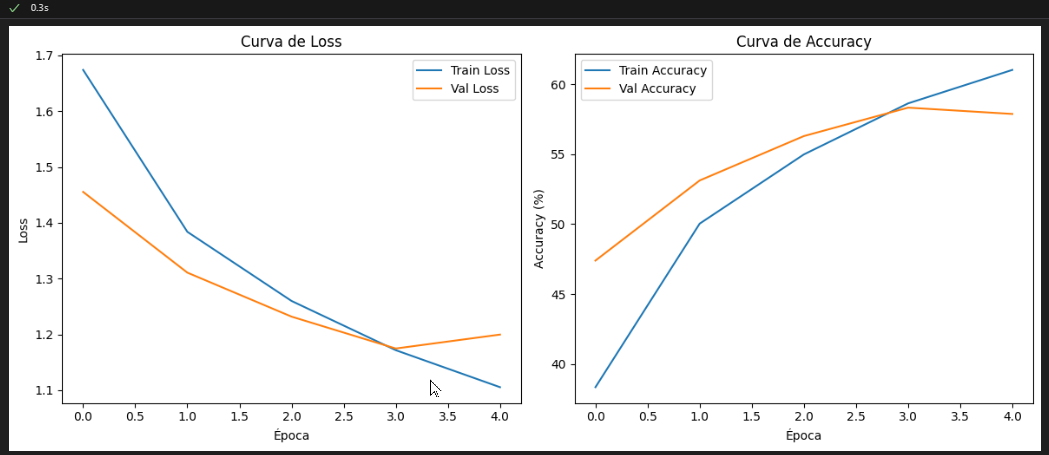


En test, a pesar de no ser necesario esta prueba:

Accuracy of the network on the 10000 test images: 57 %

Tiempo de ejecución: 489.10 segundos


**Modelo mejorado Red Neuronal 1 (validación)**
----------------

**Entrenamiento y validación:
Hiperparámetros y métricas:**

Aplico stratificación

epochs = 5

batch_size = 4

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

**Resultados en validación: Acc=75.54**

Época 1: Train Loss=1.685, Acc=39.05% | Val Loss=1.285, Acc=54.09% | Tiempo: 88.65 s

Época 2: Train Loss=1.299, Acc=54.45% | Val Loss=0.985, Acc=64.88% | Tiempo: 86.52 s

Época 3: Train Loss=1.068, Acc=62.86% | Val Loss=0.860, Acc=69.82% | Tiempo: 87.25 s

Época 4: Train Loss=0.919, Acc=68.20% | Val Loss=0.803, Acc=71.41% | Tiempo: 86.24 s

Época 5: Train Loss=0.816, Acc=71.97% | Val Loss=0.693, **Acc=75.54%** | Tiempo: 87.44 s

 Tiempo total de entrenamiento: 436.10 segundos

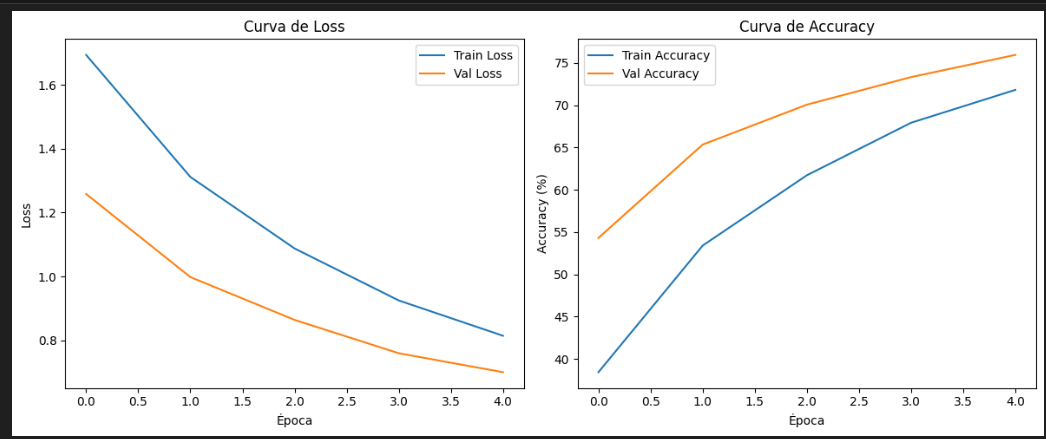

En test, a pesar de no ser necesario esta prueba:

Accuracy of the network on the 10000 test images: 70 %

Tiempo de ejecución: 529.77 segundos


**Modelo mejorado Red Neuronal 2 (validación)**
----------------

**Entrenamiento y validación:
Hiperparámetros y métricas:**

Aplico stratificación

epochs = 5

batch_size = 4

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

**Resultados en validación: Acc=70.77%**

Época 1: Train Loss=1.590, Acc=41.85% | Val Loss=1.268, Acc=52.80% | Tiempo: 89.05 s

Época 2: Train Loss=1.259, Acc=55.08% | Val Loss=0.991, Acc=64.62% | Tiempo: 90.65 s

Época 3: Train Loss=1.112, Acc=60.98% | Val Loss=0.927, Acc=66.96% | Tiempo: 90.70 s

Época 4: Train Loss=1.013, Acc=64.64% | Val Loss=0.884, Acc=68.58% | Tiempo: 93.47 s

Época 5: Train Loss=0.943, Acc=66.92% | Val Loss=0.848, **Acc=70.77%** | Tiempo: 92.74 s

 Tiempo total de entrenamiento: 456.62 segundos

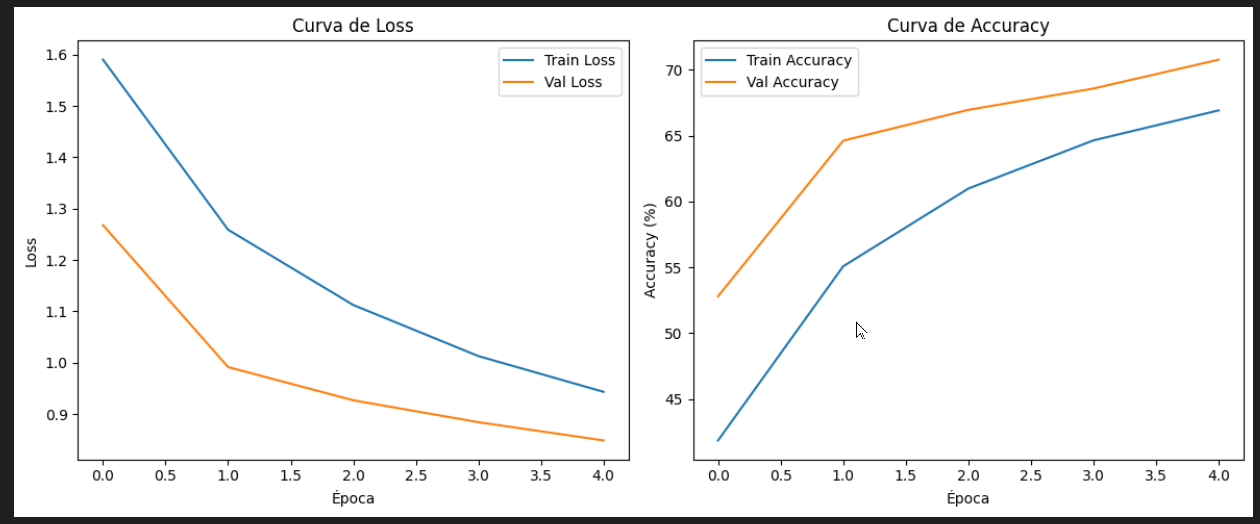

En test, a pesar de no ser necesario esta prueba:

Accuracy of the network on the 10000 test images: 65 %

Tiempo de ejecución: 544.72 segundos

**Modelo mejorado Red Neuronal 1 Con batch_size=32, epochs=10 y optimizador AdamW (mejor solución)**
----------------

**Entrenamiento y validación:
Hiperparámetros y métricas:**

Aplico stratificación

epochs = 10

batch_size = 32

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(net.parameters(), lr=0.001, weight_decay=1e-4)

**Resultados en validación: Acc=80.44%**

Época 1: Train Loss=1.489, Acc=45.55% | Val Loss=1.144, Acc=58.72% | Tiempo: 47.27 s

Época 2: Train Loss=1.144, Acc=59.35% | Val Loss=0.907, Acc=67.68% | Tiempo: 46.18 s

Época 3: Train Loss=0.975, Acc=66.01% | Val Loss=0.917, Acc=68.36% | Tiempo: 45.23 s

Época 4: Train Loss=0.871, Acc=69.60% | Val Loss=0.790, Acc=72.06% | Tiempo: 45.45 s

Época 5: Train Loss=0.784, Acc=72.94% | Val Loss=0.697, Acc=75.55% | Tiempo: 44.96 s

Época 6: Train Loss=0.715, Acc=75.20% | Val Loss=0.688, Acc=75.99% | Tiempo: 45.51 s

Época 7: Train Loss=0.657, Acc=77.29% | Val Loss=0.636, Acc=78.65% | Tiempo: 45.42 s

Época 8: Train Loss=0.604, Acc=79.31% | Val Loss=0.618, Acc=79.21% | Tiempo: 46.02 s

Época 9: Train Loss=0.564, Acc=80.56% | Val Loss=0.591, Acc=79.70% | Tiempo: 45.59 s

Época 10: Train Loss=0.519, Acc=82.24% | Val Loss=0.604, **Acc=80.44%** | Tiempo: 45.87 s

 Tiempo total de entrenamiento: 457.50 segundos

 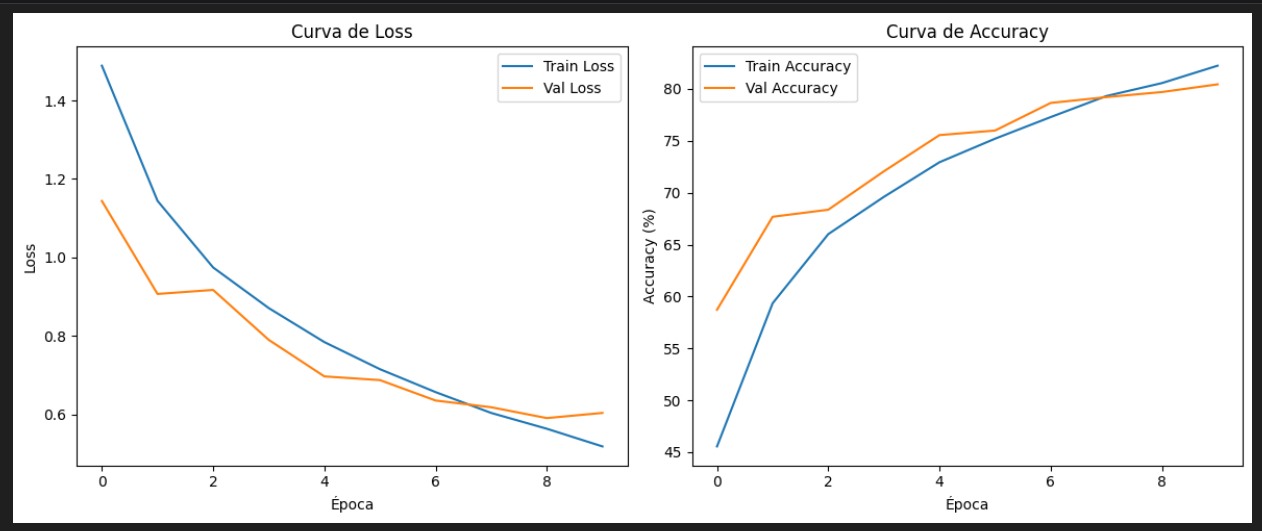

 En test, a pesar de no ser necesario esta prueba:
 
 Accuracy of the network on the 10000 test images: 76 %

 Tiempo de ejecución: 539.33 segundos

**Conclusiones y test final:**
----------------
    
La mejor configuración ha sido: **Modelo mejorado Red Neuronal 1 Con batch_size=32, epochs=10 y optimizador AdamW con un Acc=80.44% en validación**
    
1. Arquitectura más profunda y balanceada
He añadido 4 capas convolucionales frente a solo 2 en el tutorial.

Al aumentar progresivamente el número de filtros (32 → 64 → 128), se capturan características más complejas.

El uso inteligente de MaxPool2d reduce dimensiones gradualmente, evitando que la red sea demasiado pesada y manteniendo eficiencia computacional.

Esto le da a la red más capacidad para aprender patrones visuales complejos en CIFAR-10.

2. Batch Normalization tras cada convolución
BatchNorm2d después de cada Conv2d estabiliza y acelera el entrenamiento.

Reduce la sensibilidad a la inicialización y permite usar tasas de aprendizaje más altas, evitando explosiones o desapariciones de gradientes.

Mejora la estabilidad del gradiente y la generalización del modelo.

3. Dropout inteligente en dos niveles
Dropout(0.25) tras las convoluciones intermedias ayuda a evitar el sobreajuste leve.

Dropout(0.5) tras la capa densa actúa como un filtro fuerte de regularización.

Esto reduce el riesgo de que el modelo memorice el conjunto de entrenamiento.

4. Optimización con AdamW
AdamW es una mejora sobre Adam, ya que desacopla el weight decay del gradiente, lo cual mejora la regularización.

Es más robusto que SGD en redes profundas con muchos parámetros.

Contribuye a una convergencia más rápida y precisa sin necesidad de mucha afinación.

5. Batch size = 32
Un tamaño de batch moderado como 32 permite un buen equilibrio entre estabilidad del gradiente y variabilidad para generalización.

Evita tanto la varianza excesiva (batches pequeños) como el sobreajuste silencioso (batches grandes).

No sé si es debido a mi hardware o a una mala configuración pero con bartch size de 64 el equipo llegaba a reiniciarse.

6. Entrenamiento suficiente con 10 épocas
Gracias a la mejora de arquitectura y optimizador, la red puede aprender lo suficiente en solo 10 épocas.

Posilemente con más epocas se podrían mejorar ligeramente los resultados pero en este caso es un buen punto ya que empieza a converger.

Conclusión
Esta arquitectura ha mejorado el rendimiento frente al tutorial porque:

Tiene mayor capacidad de aprendizaje, pero con buena regularización.

Aplica técnicas modernas de entrenamiento (BatchNorm, Dropout, AdamW).

Está mejor diseñada para explotar la complejidad de CIFAR-10 sin caer en sobreajuste.




**Con esta configuración he entrenado el full train dataset de 50000 imágenes obteniendo los siguientes resultados: 78 % de accuracy en test**
----------------

Época 1: Loss=0.523, Accuracy=82.21%

Época 2: Loss=0.488, Accuracy=83.47%

Época 3: Loss=0.448, Accuracy=84.62%

Época 4: Loss=0.418, Accuracy=85.48%

Época 5: Loss=0.391, Accuracy=86.50%

Época 6: Loss=0.371, Accuracy=87.32%

Época 7: Loss=0.347, Accuracy=88.13%

Época 8: Loss=0.330, Accuracy=88.54%

Época 9: Loss=0.308, Accuracy=89.18%

Época 10: Loss=0.294, Accuracy=89.71%




Accuracy of the network on the 10000 test images:** 78 %**
